In [2]:
import numpy as np
from numpy.random import default_rng
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import PIL
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

ModuleNotFoundError: No module named 'numpy'

In [11]:
filepath='.'
filedir=os.path.join(os.getcwd(),filepath,'Vegetable Images')
columns=['img_name','label']
X_train=[]
y_train=[]
X_test=[]
y_test=[]
X_valid=[]
y_valid=[]

for i in os.listdir(filedir):
    ifiledir=os.path.join(filedir,i)
    for iter,j in enumerate(os.listdir(ifiledir)):
        jfiledir=os.path.join(ifiledir,j)
        for k in os.listdir(jfiledir):
            kfiledir=os.path.join(jfiledir,k)
            if(i=='train'):   
                img=np.array(PIL.Image.open(kfiledir))
                # print(img.shape)
                img.resize((224,224,3))
                X_train.append(img)      
                y_train.append(iter)
            if(i=='test'):            
                X_test.append(np.array(PIL.Image.open(kfiledir)))       
                y_test.append(iter)
            if(i=='validation'):            
                X_valid.append(np.array(PIL.Image.open(kfiledir)))       
                y_valid.append(iter)

(15000, 224, 224, 3)
[[[185 182 189]
  [185 182 189]
  [186 183 190]
  ...
  [193 193 191]
  [193 193 191]
  [193 193 191]]

 [[185 182 189]
  [185 182 189]
  [186 183 190]
  ...
  [192 192 190]
  [192 192 190]
  [192 192 190]]

 [[185 182 189]
  [185 182 189]
  [186 183 190]
  ...
  [192 192 190]
  [191 191 189]
  [191 191 189]]

 ...

 [[171 162 163]
  [172 163 164]
  [172 163 164]
  ...
  [176 175 173]
  [176 175 173]
  [176 175 173]]

 [[171 162 163]
  [171 162 163]
  [171 162 163]
  ...
  [175 174 172]
  [175 174 172]
  [175 174 172]]

 [[171 162 163]
  [171 162 163]
  [171 162 163]
  ...
  [174 173 171]
  [174 173 171]
  [174 173 171]]]


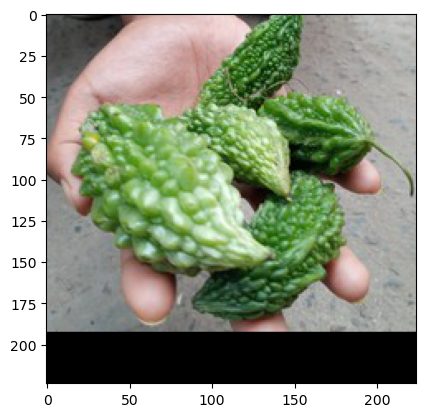

In [15]:
print(np.array(X_train).shape)
print(X_train[0])
plt.imshow(X_train[1429])

# Base Model

In [ ]:
class myNN(nn.Module):
    def __init__(self):
        super().__init__()